#### Raw Files Link
1. Create a raw folder
1. Links:
    - Salesforce SaleRep Lead pref - Deal : https://d300000001vgeeau.my.salesforce.com/00O4y000005EGd2

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('raw\sf_export_deals.csv', encoding= 'latin-1')
df.rename(columns= {'State [CC1]':'State'}, inplace = True)
df.dropna(subset= ['Opportunity ID', 'State'], inplace = True, how= 'any')

In [3]:
df_knn = pd.read_csv('raw\sf_export_deal_KNN_training_data.csv', encoding='latin-1')
df_knn.rename(columns= {'State [CC1]':'State'}, inplace = True)
df_knn.dropna(subset= ['Opportunity ID', 'State'], inplace = True, how= 'any')

In [4]:
df = pd.concat([df, df_knn])
df.reset_index(drop= True, inplace= True)

In [5]:
needed_col = [x for x in df.columns if 'Area' in x]

In [6]:
active_list = '''Robert Proden
James Harres
Beck Pemberton
Tyra Rymer
Cheri Ramos
Shanna Carmichael
Chris Hillhouse
Erik Martinez
Rachelle Westgate
Jerod Arreguini
Justin Schwartz
Dana Sirolli
Summer Lawson
Marlene Grant-Rodrigues
Michael Novi
Janine Scott
Ryan Goida
James Susuico
Natasha Montez
Jack Moller'''

active_list = active_list.split('\n')

In [7]:
df = df[df['Allocation Manager'].isin(active_list)]

In [8]:
def consolidated_values(list):
    temp_list=[]
    for value in list:
        if str(value) != 'nan':
            temp_list.append(value)
    return temp_list

df['practice_areas'] = df.apply(lambda x: consolidated_values(x[needed_col]), axis = 1)

##### Standardizing the state format

In [9]:
df['State len'] = df.apply(lambda x: len(x['State']), axis = 1)
df = df[df['State len'] == 2]
df.reset_index(drop= True, inplace= True)
df.drop(columns= ['State len'], axis = 1)
df['State'] = df.apply(lambda x: x['State'].upper(), axis= 1)

#### Converting practice area in to a sparse matrix

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('practice_areas')),
                index=df.index,
                columns=mlb.classes_))

In [11]:
needed_col = ['State', 'Lead Source', 'Allocation Manager']

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse= False)
enc_data = pd.DataFrame(enc.fit_transform(df[['State']]))
enc_data.columns = [x.split('State_')[1] for x in enc.get_feature_names(['State'])]


enc_lead_source = OneHotEncoder(sparse= False)
enc_data_lead_source = pd.DataFrame(enc_lead_source.fit_transform(df[['Lead Source']]))
enc_data_lead_source.columns = [x.split('Lead Source_')[1] for x in enc_lead_source.get_feature_names(['Lead Source'])]

In [13]:
df = df.merge(enc_data, left_index=True, right_index= True) 
df = df.merge(enc_data_lead_source, left_index=True, right_index= True) 

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Allocation Manager Encoded'] = le.fit_transform(df['Allocation Manager'])

In [15]:
col_drop = '''Deal: ID
Opportunity ID
Opportunity Owner
Order Date
Deal: Deal Name
Lead Source Name
Membership Fee (After Discount)
Down Payment / Initial Payment
Total # of Installments
Amount of Installments - Principal
Phone
Area of Practice 1
Area of Practice 2
Area of Practice 3
Area of Practice 4
Area of Practice 5
State len
Lead Source
Allocation Manager
State
Account Name'''

col_drop = col_drop.split('\n')

##### Filter columns needed for training


In [16]:
dataset = df[[x for x in df.columns if x not in col_drop]].copy()
dataset

,Administrative Law,"Bankruptcy, Banking and Credit",Business - Litigation,Business - Transactional,Class Action - Mass Tort Litigation,Construction,Consumer Law,Criminal Law,Employment and Labor Law,"Entertainment, Media, & Sports Law",...,HOTLEAD-other,HOTLEAD-phone,MM REFERRAL,RENEWAL,Refer a Colleague,SAVE,SELF GEN,Social Media Engagement,UPGRADE,Allocation Manager Encoded
0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2032,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2033,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2034,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
df['Allocation Manager'].value_counts()

Jerod Arreguini            308
Janine Scott               269
Dana Sirolli               163
Robert Proden              156
Shanna Carmichael          150
Cheri Ramos                133
Rachelle Westgate           98
Michael Novi                93
Chris Hillhouse             93
James Harres                90
Beck Pemberton              73
Justin Schwartz             70
Summer Lawson               66
Tyra Rymer                  63
Marlene Grant-Rodrigues     55
Jack Moller                 49
James Susuico               45
Ryan Goida                  30
Erik Martinez               20
Natasha Montez              12
Name: Allocation Manager, dtype: int64

##### Actual Dataset

In [18]:
input_df = pd.read_excel('input_file_v2.xlsx', sheet_name = 'input')

In [19]:
needed_col = [x for x in input_df.columns if 'Area' in x]
input_df['practice_areas'] = input_df.apply(lambda x: consolidated_values(x[needed_col]), axis = 1)

##### Standardizing the state format

In [20]:
input_df['State len'] = input_df.apply(lambda x: len(x['State']), axis = 1)
input_df = input_df[input_df['State len'] == 2]
input_df.reset_index(drop= True, inplace= True)
input_df.drop(columns= ['State len'], axis = 1)
input_df['State'] = input_df.apply(lambda x: x['State'].upper(), axis= 1)
input_df_orig = input_df.copy()

In [21]:
input_df = input_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(input_df.pop('practice_areas')),
                index=input_df.index,
                columns=mlb.classes_))

In [22]:
enc_data = pd.DataFrame(enc.transform(input_df[['State']]))
enc_data.columns = [x.split('State_')[1] for x in enc.get_feature_names(['State'])]

In [23]:
enc_data_lead_source = pd.DataFrame(enc_lead_source.transform(input_df[['Lead Source']]))
enc_data_lead_source.columns = [x.split('Lead Source_')[1] for x in enc_lead_source.get_feature_names(['Lead Source'])]

In [24]:
input_df = input_df.merge(enc_data, left_index=True, right_index= True) 
input_df = input_df.merge(enc_data_lead_source, left_index=True, right_index= True)

In [25]:
input_df = input_df.iloc[:,12:]

In [26]:
missing_col = list(set(dataset.columns) - set(input_df))
missing_col.remove('Allocation Manager Encoded')

In [27]:
for value in missing_col:
    input_df[value] = 0

In [28]:
col_order = dataset.columns.tolist()
col_order.remove('Allocation Manager Encoded')
input_df = input_df[col_order]

#### Model Training

In [29]:
y = dataset.pop('Allocation Manager Encoded')
X = dataset

##### Balancing Dataset using randome sampler

In [30]:
# from imblearn.over_sampling import RandomOverSampler 
# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)

Class=0, n=308 (5.000%)
Class=1, n=308 (5.000%)
Class=2, n=308 (5.000%)
Class=3, n=308 (5.000%)
Class=4, n=308 (5.000%)
Class=5, n=308 (5.000%)
Class=6, n=308 (5.000%)
Class=7, n=308 (5.000%)
Class=8, n=308 (5.000%)
Class=9, n=308 (5.000%)
Class=10, n=308 (5.000%)
Class=11, n=308 (5.000%)
Class=12, n=308 (5.000%)
Class=13, n=308 (5.000%)
Class=14, n=308 (5.000%)
Class=15, n=308 (5.000%)
Class=16, n=308 (5.000%)
Class=17, n=308 (5.000%)
Class=18, n=308 (5.000%)
Class=19, n=308 (5.000%)


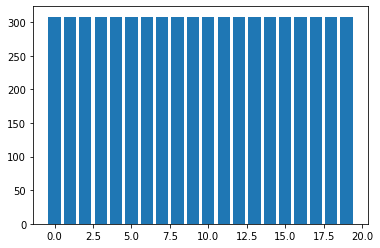

In [31]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neural_network import MLPClassifier


# solvers = ['sgd', 'adam', 'lbfgs']
# hidden_layer_sizes = [8,16,32,64,128,256,512]
# alpha = [1e-5, 1e-6, 1e-7, 1e-8]
# activations = ['identity', 'logistic', 'tanh', 'relu']
# learning_rates = ['constant', 'invscaling', 'adaptive']
# batch_sizes = [int(x) for x in np.linspace(start=200, stop=len(test_x), num=100)]


# params={
#     'solver':solvers,'hidden_layer_sizes':hidden_layer_sizes,'alpha':alpha,
#     'activation':activations, 'learning_rate':learning_rates
#     }

# clf = MLPClassifier(random_state=1, early_stopping = True)

# rcv= RandomizedSearchCV(clf, scoring=clf.score,param_distributions=params, n_iter=300, cv=5, 
#                                 random_state=42, n_jobs=-1, verbose = 10, return_train_score= True)

# rcv.fit(train_x, train_y) ##training data on randomsearch cv
# cv_best_params = rcv.best_params_ ##it will give you best parameters 
# print(f"Best paramters: {cv_best_params}")  ##printing  best parameters

In [33]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

In [34]:
dataset = X.copy()
dataset['Balanced Labels'] = y
dataset['Balanced Labels - names'] = le.inverse_transform(y)

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier


In [36]:
clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-7,
                    hidden_layer_sizes=(512,), 
                    random_state=42,
                    learning_rate='constant',
                    activation='relu')

clf.fit(train_x, train_y)   

MLPClassifier(alpha=1e-07, hidden_layer_sizes=(512,), random_state=42,
              solver='lbfgs')

In [37]:
from sklearn.metrics import accuracy_score

predictions_train = clf.predict(train_x)
predictions_test = clf.predict(test_x)
train_score = accuracy_score(predictions_train, train_y)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_y)
print("score on test data: ", test_score)

score on train data:  0.7439393939393939
score on test data:  0.5344155844155845


In [38]:
alternative = pd.read_csv('Alternative.csv')

In [39]:
pd.DataFrame(le.inverse_transform(clf.predict(input_df))).value_counts()

Dana Sirolli               39
James Harres               31
Cheri Ramos                26
Shanna Carmichael          26
Michael Novi               26
Robert Proden              24
Janine Scott               20
Jerod Arreguini            18
Beck Pemberton             15
Justin Schwartz            12
Chris Hillhouse            11
Rachelle Westgate           9
Tyra Rymer                  6
Erik Martinez               5
James Susuico               4
Summer Lawson               4
Marlene Grant-Rodrigues     2
dtype: int64

In [40]:
reference_df = pd.DataFrame(clf.predict_proba(input_df), columns= le.classes_)

temp_list = []
for index, row in reference_df.iterrows():
    temp_list.append(row.sort_values(ascending=False)[:3].to_dict())
    # break

In [41]:
for index, value in zip(input_df_orig['Lead Name'], temp_list):
    print(f"Lead Name: {index}")
    print('===============Sales Rep Options:=================')
    for key in value:
        print(f"{key}:{value[key]} : {alternative.loc[alternative['Salesrep'] == key, 'Active Rep'].values}")
    print('\n')

Lead Name: Lori J Clemons, Esq.
===============Sales Rep Options:=================
Janine Scott:0.9982014547911855 : ["['Erik Martinez']"]
Robert Proden:0.0017094386720963217 : ["['Summer Lawson']"]
Cheri Ramos:8.771835706287963e-05 : ['[]']


Lead Name: Sadara DeVonne
===============Sales Rep Options:=================
Michael Novi:0.9988955021565156 : ['[]']
Erik Martinez:0.0010630318057674101 : ["['Janine Scott']"]
Chris Hillhouse:4.022609689894922e-05 : ["['Tyra Rymer']"]


Lead Name: Julie Krzeminski
===============Sales Rep Options:=================
Jerod Arreguini:0.9970816328003895 : ['[]']
Robert Proden:0.002637402590146497 : ["['Summer Lawson']"]
Shanna Carmichael:0.00027717557964964057 : ["['James Harres']"]


Lead Name: Thomas Cattani
===============Sales Rep Options:=================
Dana Sirolli:0.8521823834295982 : ['[]']
Cheri Ramos:0.1227850681759101 : ['[]']
Michael Novi:0.023488113408087086 : ['[]']


Lead Name: Michael Lagnado
===============Sales Rep Options:=======

Rules:
1. If below 50, do not follow recommendation and use that lead to balance the distribution
    - Do not record in tracker
1. If you notice there is repeating recommended value. Take note and inform me
1. If the probability is less than 90 and the first recommended value received to much, you can assign it to the next rep
1. You can edit the active list to customize the output